# Session 5: Source Detection and Measurement
<br>Owner(s): **Imran Hasan** ([@ih64](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@ih64))
<br>Last Verified to Run: **2020-05-11**
<br>Verified Stack Release: **Weekly 2020 19.0**

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Understand how the PSF is constructed
2. Run detection on an image, along with deblending and measurement
3. Understand Footprints and HeavyFootprints, and their relationship to Detection, Deblending, and Measurement;
4. Understand some of the different measurement algorithms
5. Understand Forced Photometry, and how we combine across bands

### Logistics
This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClubCourse


You can find the Stack version that this notebook is running by using eups list -s on the terminal command line:

In [1]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list lsst_distrib -s

nb-ishasan-w-2020-19
   19.0.0-1-gc154f85+49 	current w_2020_19 setup


For this tutorial we'll need the following modules:

In [1]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl
mpl.style.use('seaborn-poster')
import matplotlib.pyplot as plt
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.display as afwDisplay
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig
from lsst.meas.algorithms import SourceDetectionTask, SourceDetectionConfig
from lsst.meas.deblender               import SourceDeblendTask
from lsst.meas.base                    import SingleFrameMeasurementTask
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig
import matplotlib.animation as animation
from matplotlib.colors import LogNorm
from IPython.display import IFrame, display, Markdown, HTML
import lsst.meas.extensions.photometryKron
import lsst.geom as lsstGeom
mpl.style.use('seaborn-poster')

## Prelude : Measuring the Point Spread Function (PSF)

The detection algorithm used in the DM stack uses the transpose of the PSF as a detection kernel. So before we dive into detection, we will discuss how the PSF is constructed in the stack. This is handled in a high level task called `CharacterizeImage`. 

We will need an image to run on for this section. Let's grab a `calexp`, (a single processed CCD image) to use for this section. `calexps` are used for calibrating things like astrometry and estimating the point spread function, and they are not expected to be distributed as a high-level science product. Nonetheless, it will give us a great opportunity to understand PSF estimation. 

In [2]:
band = 'HSC-I'
depth = 'WIDE' # WIDE, DEEP, UDEEP
field = 'SSP_WIDE' # SSP_WIDE, SSP_DEEP, SSP_UDEEP
butler = dafPersist.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))
subset = butler.subset('calexp', dataId={'filter':band, 'field':field})
dataId = subset.cache[5]
calexp = butler.get('calexp', **dataId)

Roughly speaking, `CharacterizeImage` PSF estimation will first use a simple Gaussian PSF as a place holder to detect very bright sources, identify point sources that can be used to model the PSF, and finally model the PSF. Let's setup and run it now

In [3]:
#Set up the task, it requires a config when we instantiate it
charConfig = CharacterizeImageConfig()
charImageTask = CharacterizeImageTask(None, config=charConfig)
#run the task on our exposure and save the output. This takes a minute to run 
charResult = charImageTask.run(calexp)

Let's take a quick look at the output catalog. It is convinient to print it as an astropy table so we can see all the columns. There are *a lot* of columns, often several for each measurement algorithm being run. We will revisit measurement later in this notebook, but for now take note of the `calib_psf_candidate` and `calib_psf_used` columns. This tells us if the source was a candidate to be used for modeling the PSF, and if it was actually used. 

In [4]:
charResult.sourceCat.asAstropy()

id,coord_ra,coord_dec,parent,calib_psf_candidate,calib_psf_used,calib_psf_reserved,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,slot_Centroid_flag_notAtMaximum,base_SdssCentroid_flag_resetToPeak,base_CircularApertureFlux_flag_badCentroid_resetToPeak,base_GaussianFlux_flag_badCentroid_resetToPeak,base_PsfFlux_flag_badCentroid_resetToPeak,base_SdssShape_flag_badCentroid_resetToPeak,slot_Centroid_flag_resetToPeak,base_SdssCentroid_flag_badError,base_CircularApertureFlux_flag_badCentroid_badError,base_GaussianFlux_flag_badCentroid_badError,base_PsfFlux_flag_badCentroid_badError,base_SdssShape_flag_badCentroid_badError,slot_Centroid_flag_badError,base_SdssShape_xx,slot_Shape_xx,base_SdssShape_yy,slot_Shape_yy,base_SdssShape_xy,slot_Shape_xy,base_SdssShape_xxErr,slot_Shape_xxErr,base_SdssShape_yyErr,slot_Shape_yyErr,base_SdssShape_xyErr,slot_Shape_xyErr,base_SdssShape_x,slot_Shape_x,base_SdssShape_y,slot_Shape_y,base_SdssShape_instFlux,slot_Shape_instFlux,base_SdssShape_instFluxErr,slot_Shape_instFluxErr,base_SdssShape_psf_xx,slot_PsfShape_xx,slot_Shape_psf_xx,base_SdssShape_psf_yy,slot_PsfShape_yy,slot_Shape_psf_yy,base_SdssShape_psf_xy,slot_PsfShape_xy,slot_Shape_psf_xy,base_SdssShape_instFlux_xx_Cov,slot_Shape_instFlux_xx_Cov,base_SdssShape_instFlux_yy_Cov,slot_Shape_instFlux_yy_Cov,base_SdssShape_instFlux_xy_Cov,slot_Shape_instFlux_xy_Cov,base_SdssShape_flag,base_GaussianFlux_flag_badShape,slot_Shape_flag,base_SdssShape_flag_unweightedBad,base_GaussianFlux_flag_badShape_unweightedBad,slot_Shape_flag_unweightedBad,base_SdssShape_flag_unweighted,base_GaussianFlux_flag_badShape_unweighted,slot_Shape_flag_unweighted,base_SdssShape_flag_shift,base_GaussianFlux_flag_badShape_shift,slot_Shape_flag_shift,base_SdssShape_flag_maxIter,base_GaussianFlux_flag_badShape_maxIter,slot_Shape_flag_maxIter,base_SdssShape_flag_psf,base_GaussianFlux_flag_badShape_psf,slot_Shape_flag_psf,base_CircularApertureFlux_3_0_instFlux,base_CircularApertureFlux_3_0_instFluxErr,base_CircularApertureFlux_3_0_flag,base_CircularApertureFlux_3_0_flag_apertureTruncated,base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_4_5_instFlux,base_CircularApertureFlux_4_5_instFluxErr,base_CircularApertureFlux_4_5_flag,base_CircularApertureFlux_4_5_flag_apertureTruncated,base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,base_CircularApertureFlux_6_0_instFlux,base_CircularApertureFlux_6_0_instFluxErr,base_CircularApertureFlux_6_0_flag,base_CircularApertureFlux_6_0_flag_apertureTruncated,base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,base_CircularApertureFlux_9_0_instFlux,base_CircularApertureFlux_9_0_in

The Science Pipelines identify sources on the stellar locus in a magnitude vs size diagram to pick out candidates for determining the PSF. Let us try to visualize this now by plotting all the sources in magnitude-size space, and color code points that were PSF candidates as orange. If you browsed the output table above, you would have noticed that the Science Pipelines report instrumental fluxes, and not magnitudes. To get magnitudes, we need to do a bit of leg work. We will call the `photoCalib` associated with our `calexp`. This will tell us how to get magnitudes out of our instrumental fluxes. We will pass in the catalog along with the flux column we want to use to the `instFluxToMagnitude` method. For now lets keep things simple and use 12 pixel aperture photometry to get our magnitudes. For sizes, we will get a rough estimate by adding the second moments together from the SloanShape algorithm.

Text(0.5, 0, 'Magnitude')

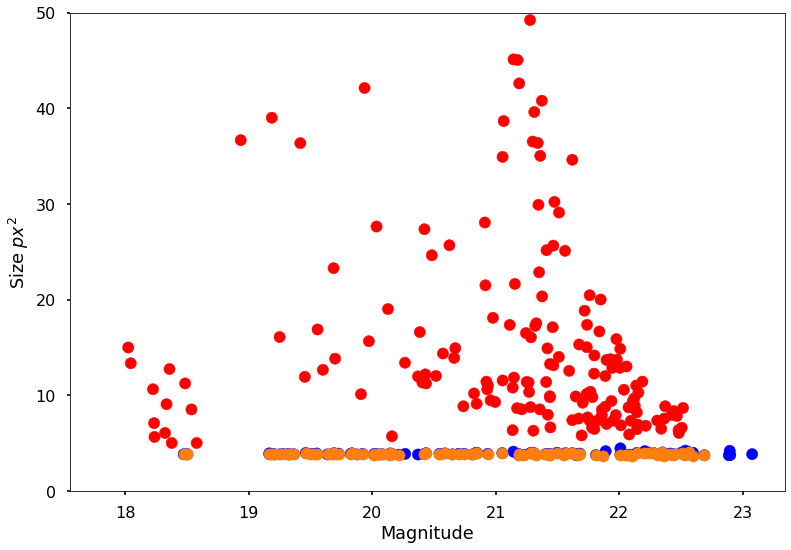

In [5]:
# calculate the magnitude and magnitude error for sources
# we grab the photoCalib from the calexp, and use its instFluxToMagnitude method
# instFluxToMagnitude can return a vector of magnitude and magnitude errors if you pass in
# your source catalog and the name of the flux measurement algorithm you want to use
apMag = calexp.getPhotoCalib().instFluxToMagnitude(charResult.sourceCat,'base_CircularApertureFlux_12_0')
# use the sloan algorithm to calculate something like a size
size = charResult.sourceCat['base_SdssShape_xx'] + charResult.sourceCat['base_SdssShape_yy']
# mask if it was not a PSF candidate
calib_mask = charResult.sourceCat['calib_psf_candidate']

# color the points by their extendendness, it will be red for resolved sources and blue for point sources
plt.scatter(apMag[:,0], size, c=charResult.sourceCat['base_ClassificationExtendedness_value'],
           cmap='bwr')
# over plot PSF candidates in orange
# to get the magnitues we just need the first column from apMag
# the second column would give you magnitude errors
plt.scatter(apMag[:,0][calib_mask], size[calib_mask], color='C1')
plt.ylim([0,50])
plt.ylabel('Size $px^2$')
plt.xlabel('Magnitude')

We can see all the point sources (colored in blue) live on the 'stellar locus' in this diagram, and the candidate PSF stars (orange) in fact live on the stellar locus. The extended sources shown in red are likely bright galaxies that were detected.

In [6]:
# now lets verify that the calexp has a psf object 'attached' to it
calexp.hasPsf()

True

We can exercise the PSF to evaluate it at different locations on the detector. However, it will require we pass it an `lsst.geom.Point2D` object that defines that location. We demonstrate a simple example below before moving onto more complicated tricks

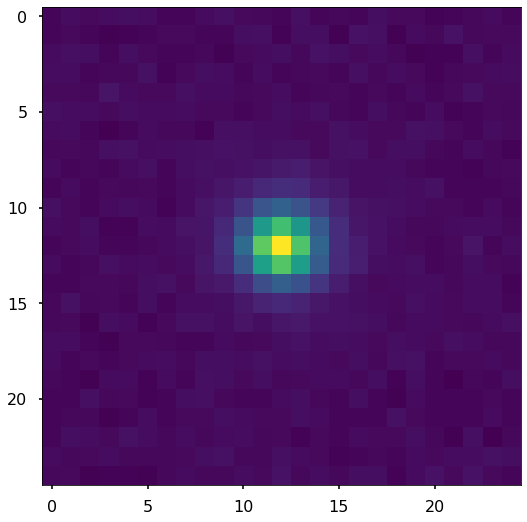

In [7]:
myPoint = lsstGeom.Point2D(400,500)
myPsf = calexp.getPsf().computeImage(myPoint)
plt.imshow(myPsf.getArray())

We can visualize how good of a job the stack did in giving us a PSF. We can use the stars that were PSF candidates but ultimately not used, to validate the PSF model. Let's look at the residuals of the PSF model evaluated at the location of these reserve stars, and the reserve stars themselves. This exercise is borrowed from Rober Lupton's [PSF.ipynb](https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/PSF.ipynb)

In [8]:
# setup a mask to give us stars that were PSF candidates but ultimately not used for PSF estimation
calib_not_used = np.logical_and.reduce([charResult.sourceCat['calib_psf_candidate'],
                                        ~charResult.sourceCat['calib_psf_used'],
                                        charResult.sourceCat['base_PixelFlags_flag_saturatedCenter'] == 0])
# grab the cadidate-but-not-used stars
reserve_sources = charResult.sourceCat[calib_not_used]

Now we are prepared to visualize some PSF model residuals. We will evaluate the PSF at the location of some candidate stars which were not used to make the PSF. Then we will take the difference between the model and the actual star

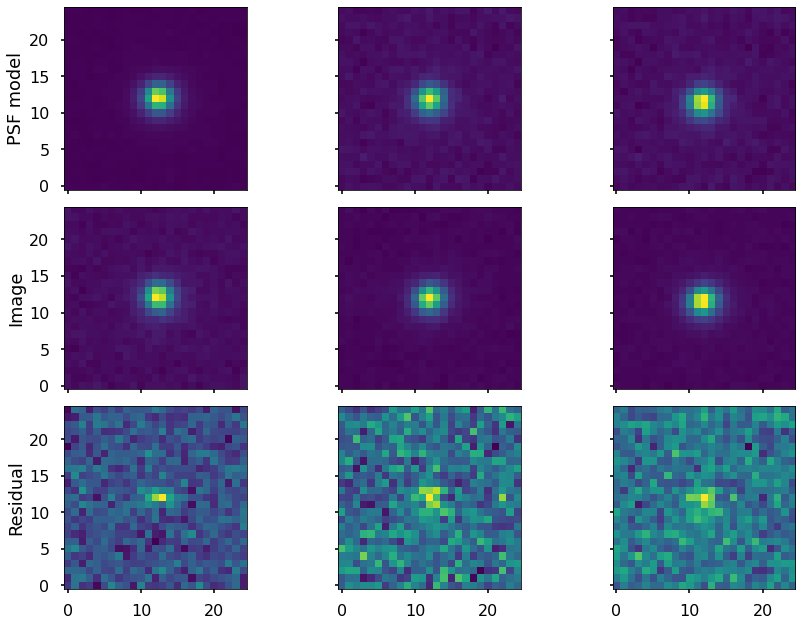

In [9]:
residuals = calexp.getMaskedImage().getImage().clone()
psf = calexp.getPsf()

f, ax = plt.subplots(ncols=3, nrows=3, sharex=True, sharey=True)
for i in (0,1,2):
    # we can evaluate the PSF at different locations on the CCD
    # lets evaluate it at the location of our reserve sources
    psfImage = psf.computeImage(reserve_sources[i].getCentroid()).convertF()
    # we should scale up the modle PSF so its flux matches that of the star we will compare it too
    psfImage *= reserve_sources[i].getPsfInstFlux()/np.sum(psfImage.getArray())
    ax[0,i].imshow(psfImage.getArray(), origin='lower') #plot the model PSF
    ax[1,i].imshow(residuals[psfImage.getBBox()].getArray(), origin='lower') #plot the star
    ax[2,i].imshow(psfImage.getArray() - residuals[psfImage.getBBox()].getArray(), origin='lower') #plot residuals

ax[0,0].set_ylabel('PSF model')
ax[1,0].set_ylabel('Image')
ax[2,0].set_ylabel('Residual')
plt.tight_layout()

### EXERCISE
Make a plot showing the difference between the model PSF evaluatad at two different arbitrary points
The PSF is spatially varying, so the PSF at two different points should be different. Remember you need to pass in lsstGeom.Point2D to the PSF model

In [ ]:
# put your code here

## Introduction to SourceDetectionTask

We will now examine the source detection task. Typically, source detection is a subtask of some other higher level tasks. For example, detection is used multiple times in ProcessCcd.py, which you learned about in the previous lesson with Andrew Bradshaw. And it was used as a subtask to CharacterizeImage above. While that is the norm, it will be useful to start of working with the SourceDetectionTask on its own so we can get to know it a little better.

As we learned in previous lessons, `calexp` objects contain a mask plane, where pixels are marked as being DETECTED, among other properties. This calexp we are working with has already been processed, and so it's mask plane already has marked pixels. Let's clear out the mask plane so that we can have a clean slate to work with. 

In [10]:
calexp.mask.clearAllMaskPlanes()

Now that we have an image to work with, we will set up a minimal source detection task which we will run on our calexp. Detection requires that we pass a schema for a catalog to it to begin with. That schema will be used to populate a catalog with data from detection. Let's set up a minimal schema to start with. 

In [11]:
schema = afwTable.SourceTable.makeMinimalSchema()

We also need to pass a `config` to our detection task when we instantiate it. Tasks have configs, which let you adjust certain parameters of the task to adjust it to your specific needs. You can usually find a task's config in the same file as the task. To see all the adjustable parameters, you can take a look [the detection source code on github](https://github.com/lsst/meas_algorithms/blob/master/python/lsst/meas/algorithms/detection.py). It will also allow you to see what types are allowed per each parameter, e.g. thresholdType expects a string, and specifically one of the following "stdev", "variance", "value", or "pixel_stdev", while thresholdValue expects a float larger than 0.0. While there are many to choose from, for now, we will set parameters that you are most likely to be interested in.

In [12]:
#create an instance of the source detection config
config = SourceDetectionTask.ConfigClass()
#drill down on the atributes of the config and set them 
config.thresholdType = 'stdev'
config.thresholdValue = 5.0 #we want 5 sigma detection threshold
config.includeThresholdMultiplier = 1.0 # this scales the threshold value, so that the threshold is thresholdValue*thresholdMultiplyer
config.minPixels = 5 # sources less with fewer than 5 pixels will not be counted as detected sources

We are now ready to create an instance of the source detection class

In [13]:
srcDetection = SourceDetectionTask(config=config, schema=schema)

While we are here and  have our schema defined, we will also define our deblending task and source measurement task as well. We will use them later in this notebook

In [14]:
sourceDeblendTask   =   SourceDeblendTask(schema=schema)
measConfig = SingleFrameMeasurementTask.ConfigClass()
measConfig.plugins.names.add('ext_photometryKron_KronFlux')
sourceMeasurementTask = SingleFrameMeasurementTask(schema=schema, config=measConfig)

Tasks have a run method, a high level method that does everything the task is meant to do. We saw this previously when we ran `characterizeImage`. Lets finally run our calexp through detection. This will require a table to populate with results, as well as the calexp we want to run detection on.

In [15]:
tab = afwTable.SourceTable.make(schema)
detRes = srcDetection.run(tab, calexp)

We get several data products back from detection. `detRes` is a type `struct`. We can view the items it contains by asking to treat it like a python dictionary. 

In [16]:
for k,v in detRes.getDict().items():
    print(k, type(v))

positive <class 'lsst.afw.detection.FootprintSet'>
negative <class 'NoneType'>
factor <class 'float'>
background <class 'lsst.afw.math.backgroundList.BackgroundList'>
numPos <class 'int'>
numPosPeaks <class 'int'>
numNeg <class 'int'>
numNegPeaks <class 'int'>
fpSets <class 'lsst.pipe.base.struct.Struct'>
sources <class 'lsst.afw.table.SourceCatalog'>


We will delve into footprints, and peaks later in this notebook.  We have previously seen a bit of the source catalog earlier in this notebook, but we will take a closer look at it later when we discuss source measurement.

Our calexp itself has also been changed by running the detection task. It's mask plane has now been updated by the detection algorithm. Lets look at the mask plane bit values

In [17]:
calexp.getMask().getMaskPlaneDict()

{'BAD': 0,
 'CR': 3,
 'CROSSTALK': 9,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'INTRP': 2,
 'NOT_DEBLENDED': 10,
 'NO_DATA': 8,
 'SAT': 1,
 'SUSPECT': 7,
 'UNMASKEDNAN': 11}

The mask bit values are the exponent of the bitmask. For example, pixels only marked detected will have a value of 2^5 = 32, while pixels that are both on the edge and detected will be 2^5 + 2^4 = 48.

Finally we can visualize a small corner of our image. Detected objects will have a blue overlay, while interoplated pixels will have a green overlay, pixels close to the edge will be yellow, and bad pixels will have red overlay. For more information on how colors map to mask bits, you can view the documentation [here](https://pipelines.lsst.io/v/DM-11392/getting-started/display.html#interpreting-displayed-mask-colors)

(-0.5, 999.5, -0.5, 999.5)

<Figure size 921.6x633.6 with 0 Axes>

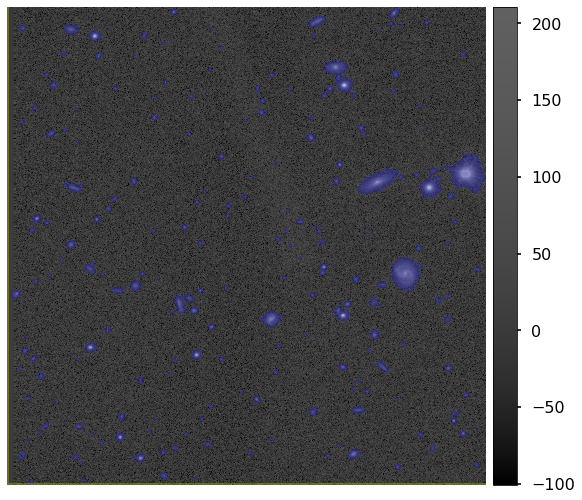

In [18]:
afwDisplay.setDefaultBackend('matplotlib') 
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage()[:1000,:1000])
plt.gca().axis('off')

We also recieve a source catalog. Let's take a peek at it

In [ ]:
sources = detRes.sources
sources

The resulting table doesn't say very much right now                      . This is because we only ran detection, and the table merely gives us information on detected sources--i.e., their ID, position, and 'parent'. The parent value for a source is 0 if it is its own parent, otherwise it will be the id of its parent source from which it was deblended. All of the sources have 0 as their parent right now, because we have not run deblending. Later on we will run deblending and source measurement as well, the resulting table will be more substantive. Before we go onto deblending and measurement, we will examine Footprints, another data product produced by detection.

## Altering the PSF for detection

The transpose of the PSF is formally the optimal filter for isolated point sources in the limit that the background is known perfectly and noise is dominated by the sky. But what if you are interested in detecting something else, and therefore want to tweak the detection kernel? We will take a moment to examine the effects of convolution with different PSFs to see the effect it has on convolution. This section is borrowed from Alex Drlica-Wagner's [Low Surface Brightness](https://nbviewer.jupyter.org/github/LSSTScienceCollaborations/StackClub/blob/rendered/SourceDetection/LowSurfaceBrightness.nbconvert.ipynb) Stack Club Notebook.

Something we can tinker with is the width of a gaussian PSF. We are going to delve into the guts of the [Source Detection Task](https://github.com/lsst/meas_algorithms/blob/master/python/lsst/meas/algorithms/detection.py) so we can gain some intuition for how convolution happens, and how the PSF factors into it. If we look at the [getPsf](https://github.com/lsst/meas_algorithms/blob/master/python/lsst/meas/algorithms/detection.py#L486) method, we can see that if we specify the parameter sigma, a Gaussian PSF with width sigma will be used to perform convolution in lieu of the PSF that is attached to the `calexp`. Going a little further down, we can see the 
[convolveImage](https://github.com/lsst/meas_algorithms/blob/master/python/lsst/meas/algorithms/detection.py#L513) method is where the actual convolution happens. Let's do an exercise where we pass in increasingly wider PSFs to use in convolution, and visualize the effect they have on the smoothed images.

In [ ]:
doSmooth = True # actually do the smoothing

# Loop over PSF convolution size in pixels
for i,sigma in enumerate([5, 7, 10]):
    # Make a deep copy of the calexp
    exp = calexp.clone()
    
    # this will give us a gaussian PSF with width sigma
    psf = srcDetection.getPsf(exp, sigma=sigma)
    convolveResults = srcDetection.convolveImage(exp.getMaskedImage(), psf, doSmooth=doSmooth)
    middle = convolveResults.middle
    sigma = convolveResults.sigma

    plt.figure(i, figsize=(5,5))
    afw_display = afwDisplay.Display(frame=i)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(middle.image[:1000,:1000])
    plt.gca().axis('off')
    plt.title("Convolution Kernel: %s pix"%sigma)

We can see the detection kernel's width affects the degree to which features 'pop out' in the smoothed images. In particular, broadening the filter has the effect of giving more contrast to larger more diffuse sources.

As Alex shows in his notebook, once you have settled on a sigma that suits your best detection needs, you can perform detection using your user defined sigma. Looking at the [run method](https://github.com/lsst/meas_algorithms/blob/master/python/lsst/meas/algorithms/detection.py#L298), we can see if you use the call pattern `srcDetection.run(tab, calexp, sigma=mySigma)` detection will carry on using a kernel with the specified width instead of the default width defined by the PSF. In Alex's notebook, we see that by broadening the detection filter, he is able to detect a low surface brightness galaxy that was missed in the initial detection pass(!)

## Footprints

Along with an updated mask plane to the calexp, and a minimal source catalog, detection also produces objects called `Footprints`. To start our discussion to Footprints we can draw an analogy between them and segmentation maps from Source Extractor, as they both identify above threshold pixels. As we first introduce footprints, we will concentrate on this similarity as it gives us a place to start understanding the location and gemoteric properties of footprints. We will soon see, however, that they are much more powerful, and play a role in deblending and source measurement.

Lets grab the positive footprints from our detection result, and introduce some basic methods footprints have that inform us of their location and geometry, and build some inutition for them.

In [ ]:
fpset = detRes.fpSets.positive
#fps will be a list of the footprints
fps = detRes.fpSets.positive.getFootprints()

In [ ]:
#This will return a rectangle in pixel coordinates of the CCD that the first footprint lies on
fps[0].getRegion()

In [ ]:
#center of the footprint in detector coordinates
fps[0].getCentroid()

In [ ]:
#the smallest box you could enscribe around the footprint
#not all the pixels in the bounding box strictly belong to the footprint, 
#since the footprint isnt necessarily rectangular
fps[0].getBBox()

In [ ]:
#area of the Footprint, not to be confused with the area of the bounding box
fps[0].getArea()

Right now the footprints do not know about the data contained in the pixels that they identify. We can fix this by defining `HeavyFootprints`. HeavyFootprints have all the qualities of Footprints, but additionally 'know' about pixel level data from their calexp's image, variance, and mask planes. Right now we can see the footprints are not 'heavy'

In [ ]:
fps[0].isHeavy()

We can make the parent footprint set heavy by passing in the calexp, then confirm our HeavyFootprints are indeed heavy.

In [ ]:
fpset.makeHeavy(calexp.getMaskedImage())
# we have to redefine fps
hfps = fpset.getFootprints()

In [ ]:
hfps[0].isHeavy()

Now we can dump the pixel values for our heavy footprints. However, we will get back a flatted 1D array. To restructure this 1D array into the 2D array as it appears on the CCD, we will need to use the heavy footprints' `span`.

NB I went ahead and shearched for a footprint that would correspond do a nice image :) feel free to choose a different HeavyFootprint

In [ ]:
hfps[21].getImageArray()

We get information about which pixels in the footprint's bounding box actually belong to the footprint by using its `Span`. The span is an n x m matrix, where n and m are the height and width of the bounding box, respectively. If an element in the span is zero, this means the pixel is inside the footprint's bounding box but does not belong to the footprint. If an element is one, the pixel is both in the bounding box and associated with the footprint.

In [ ]:
hfps[21].getSpans()

We can use the spans and the pixel level information from the heavy footprints to rebuild the footprint image. In particular, you want to use the `unflatten` method from the spans to reshuffle the 1D image data into 2 dimensions as it appears on the CCD.

In [ ]:
plt.imshow(hfps[21].getSpans().unflatten(hfps[21].getImageArray()),
          norm=LogNorm(vmin=0.01, vmax=500))

## Erosion and Dilation on Footprints

We can grow or shrink footprints by using the `dilate()` and `erode()` methods. You may imagine using dilate if you want to ensure you are getting all the flux associated with the detected source, and you may imagine using erode if you want to chip away at the edges of a footprint, making it smaller. Using these methods requires that we provide a scale by which to grow or shrink the footprint. This scale is often related to the PSF scale, e.g., the RMS or σ of a gaussian PSF multiplied by a user defined factor. In the dilation process, a circular stencil-whose size is set by the scale the user passes in-is run along the edge of the spanset of the footprint, growing it. During erosion, the stencil is passed along the edge of the span set, this time shrinking it.

Let's demonstrate this below

In [ ]:
# first get the length scale of the PSF 
psf = calexp.getPsf()
sigma = psf.computeShape().getDeterminantRadius()

# print how many pixels belong to the footprint before we dilate it
print('before dilating the footprint has an area of {}'.format(hfps[0].getArea()))

# now we will grow the footprint by 2 x sigma. We need to pass an int
hfps[0].dilate(int(2*sigma))

# print how many pixels belong to the footprint ater dilation
print('after dilating the footprint has an area of {}'.format(hfps[0].getArea()))

In [ ]:
# lets chip away at the footprint by using the erode method now
hfps[0].erode(int(2*sigma))

# print how many pixels belong to the footprint ater dilation
print('after eroding the footprint has an area of {}'.format(hfps[0].getArea()))

### EXERCISE
Count the number of peaks in a footprint. Then Erode it and report the number of peaks after erosion.
You can get a table of the peaks by using the .getPeaks(deep=True) method on a a footprint
Be sure to choose a footprint that has a fair number of peaks so you can see the effect of erosion

In [ ]:
# Your code here


### EXERCISE

Make two plots of a footprint by uising its span. First, plot an image of a footprint and overlay the peaks associated with it as red crosses. In the second plot, erode the footprint and overlay the remaining peaks still in the footprint again with red crosses. This will give you a better visualization of how erosion works and how it leads to culling peaks

In [ ]:
# Your code here


## Deblending and Source Measurement

Like `CharacterizeImage`, and `SourceDetection`, deblending and measurement are also tasks that have their own run methods. Both of these tasks operate on Footprints, so our discussion in the previous section will be highly relevant.

A blend is considered to be a footprint that contains more than one peak. A footprint's peaks are assumed to belong to distinct astrophysical sources. The deblender's job is to allocate flux from the parent footprint to the different peaks, and assign them their own deblended child footprints. That is to say, in addition to identifying the location and real estate on the CCD that blended sources occupy, the deblender also allocates flux from the parent object to its deblended children. As a result, the flux in a deblended heavy footprint will not necessarily equal the flux at the same pixels in its image, since the pixels are shared between the parent and child footprints. This is a departure from something like `Source Extractor`, where ou merely get segmentation maps. 

After deblending is run, we run source measurement. During this process footprints are all exchanged with noise, and footprints are individually inserted, measured, and replaced with noise. We will visualize this process later in this notebook.

Now that detection has been run, we can pass our calexp and source catalog to the deblender, which will separate sources out into their own footprints. Subseqently, we will run source measurement so that each footprint will be measured by several algorithms. Lets run them now

In [ ]:
#Source deblending
sourceDeblendTask.run(calexp, sources)
#Source measurement
sourceMeasurementTask.run(measCat=sources, exposure=calexp)

Notice that the new catalog contains new `deblended_` columns that the deblender imparted to it. The deblended_nChild column tells you how many child sources this source created. The parent column will list zero if this source has no parent (it was not deblended) or the object ID of its parent source if it was deblended. 

There are also several detection algorithms that have been run, each imparting several columns to the catalog as well. 

In [ ]:
sources = sources.copy(deep=True)
sources.asAstropy()

### EXERCISE
Make a plot showing how well aperture magnitudes agree with kron magnitudes
The x axis should be the aperture magnitude, and the y axis will be the difference between aperture magnitude and kron magnitude
You can search the schema for the column names you will need by doing sources.getSchema().extract('\*Kron\*'), or sources.getSchema().extract(\*CircularApertureFlux_12_0\*). This exercise is borrowed from Robert Lupton's [Kron.ipynb](https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Kron.ipynb)

In [ ]:
# Your code here

we will do an exercise together that will help us gain intuition for how delbending works and how source measurement works. First lets grab an object that has many deblended children. Note, that the next few cells will involve some tricks with afwTables. We will explain step by step what is happening with comments, but going into detail on afwTables is outside the scope of our notebook. If you would like to know more about afwTables, you can checkout [the afw table guided tour](https://nbviewer.jupyter.org/github/LSSTScienceCollaborations/StackClub/blob/rendered/Basics/afw_table_guided_tour.nbconvert.ipynb)

In [ ]:
# First get the key for the deblend_nChild field, and id. We need these to sort on them
nChild_key = sources.getSchema().find('deblend_nChild').key
idKey = sources.getIdKey()

# Sort the catalog on number of children
sources.sort(nChild_key)
# The catalog is sorted low to high, so grab an element towards the end
# Use the nChild key to get the number of children, and the id key to get the parent's ID
# The first few sources with many children are very bright stars that have been shreded
# I took the liberty of finding a nice source that has blended galaxies for you
num_children = sources[-14].get(nChild_key)
parent_id = sources[-14].getId()

# Footprints are stored in the source catalog, we can access them easily
parent_fp = sources[-14].getFootprint()
print('Parent source {} has {} deblended children'.format(parent_id, num_children))

The footprint of the parent object contains catalog of the peaks it contains. This catalog gives the peaks and their locations and peak pixel value in the smoothed image. During the detection process, the image in question is smoothed with a spatial filter. A nice demonstration of this is avaliable in the [LowSurfaceBrightness notebook](https://nbviewer.jupyter.org/github/LSSTScienceCollaborations/StackClub/blob/rendered/SourceDetection/LowSurfaceBrightness.nbconvert.ipynb). The peaks' centers and counts are in this smoothed image, and may differ slightly from their subsequent children footprints after deblending.

In [ ]:
peaks = parent_fp.getPeaks().copy(deep=True)
peaks

Now we will set up a visualization to see our parent source, the locations of its peaks (as red crosses), and the centers of the deblended children footprints (as orange circles).

In [ ]:
# Get the centroid of the parent
# So we can zoom in on it when we display it
parent_x = sources[-14].getX()
parent_y = sources[-14].getY()

parent_x = int(parent_x)
parent_y = int(parent_y)

In [ ]:
# Sort the catalog on ID 
# It needs to be sorted on ID so we can use the getChildren method
sources.sort(idKey)
# child_cat is a smaller afwTable that only has the deblended children
child_cat = sources.getChildren(parent_id)

Now we will use afwDisplay to zoom in on the parent source's location, and use the child_cat to overplot the peaks in orange circles and centers of the deblended children in red croses. You will notice they are not completely coincident, and that is because the peak locations are in the smoothed image, as we mentioned above. 

You will also notice that there are some circle's and crosses where-by eye-it's not clear that there is a astropysical source. Although we can't say for sure since we do not know the ground truth, there's a strong chance these are just noise peaks that were found in the extended tails of the diffuse galaxies' tails in the frame. None the less, these are regarded as true astrophysical sources in the stack. As a result, the deblender will consider them and appropriate flux to them. Subsequently the Source Measurement Task will perform measurements on these deblended children as well.  

In [ ]:
# credit to ADW for this afwDisplay snippet
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage()[parent_x-100:parent_x+100, parent_y-100:parent_y+100])

# We use display buffering to avoid re-drawing the image after each source is plotted
with afw_display.Buffering():
    # loop over child footprints, placing a red plus on their centers
    for s in child_cat:
        afw_display.dot('+', s.getX(), s.getY(), ctype=afwDisplay.RED)
    # loop over peaks, placing an orange circle on their centers    
    for p in parent_fp.getPeaks():
        afw_display.dot('o', p.getIx(), p.getIy(), ctype=afwDisplay.ORANGE, size=4)

We will concentrate on this example to help us visualize how measurement works on deblended sources. Drawing from the HSC Pipeline paper, the high level steps are outlined below

> 1. We replace all Footprints in the image with random Gaussian noise with the same variance as the original noise in those pixels.
2. We insert the deblended pixels for a particular source to be measured back into the image (replacing the noise pixels).
3. We run all measurement plug-ins on the current source.
4. We re-replace the Footprint of the current source with noise.
5. Repeat this process for the next Footprint

To exchange footprints with noise, and insert them back into the image, we will use an object called the `NoiseReplacer`. To set it up we need to provide it with a dictionary that contains source IDs as keys, and a tuple pair of parent ID and footprint.

In [ ]:
fp_dict = {measRecord.getId(): (measRecord.getParent(), measRecord.getFootprint())
                      for measRecord in sources}

nr_config = NoiseReplacerConfig()
noiseReplacer = NoiseReplacer(nr_config, calexp, fp_dict)

In [ ]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage()[parent_x-100:parent_x+100, parent_y-100:parent_y+100])

As advertised above, the image now only contains noise, as all the detected footprints have been replaced. Now we will insert the parent source back into the frame. A series of measurements would then be applied to the source, while all other detected sources are still replaced with noise.

In [ ]:
noiseReplacer.insertSource(parent_id)

In [ ]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage()[parent_x-100:parent_x+100, parent_y-100:parent_y+100])

In [ ]:
# we will need the ids of the deblended children so we can insert them
# back into the image one at a time
child_ids = child_cat['id'].tolist()

In [ ]:
fig = plt.figure()

ims = []

src_ids = [parent_id] + child_ids #tack on the parent ID to the list

for i in src_ids:
    # replace the ith source using noiseReplacer
    noiseReplacer.insertSource(i)
    # grab a postage stamp centered on the parent object and plot it
    data = calexp.getMaskedImage()[parent_x-100:parent_x+100, parent_y-100:parent_y+100].getImage().array
    im = plt.imshow(data, origin='lower', animated=True, vmin=-100, vmax=100, visible=False)
    # keep a running list of our plotted images so we can make a movie out of them later
    ims.append([im])
    noiseReplacer.removeSource(i)

# the plt.close catches a spurious extra image
plt.close()

# organize our plotted images into an animation
HTML(animation.ArtistAnimation(fig, ims, interval=1000, blit=True,
                                repeat_delay=1000).to_jshtml())
# takes a minute to get going, 

Let's make a similar visualization, now showing mug shots of all of the deblended sources. 

### EXERCISE
Familiarize yourself with the noise replacer.
Finish the missing code in following for loop so that we make mugshots of the parent and 9 deblended children objects. You can iterate over the `src_ids` list

In [ ]:
f, ax = plt.subplots(nrows=3, ncols=3, sharey=True, sharex=True, figsize=(12,8))

for i, a in zip(range(0, 9), ax.flatten()):
    noiseReplacer.insertSource() # fill in the argument here
    data = calexp.getMaskedImage()[parent_x-100:parent_x+100, parent_y-100:parent_y+100].getImage().array
    a.imshow(data, origin='lower', vmin=-100, vmax=100)
    noiseReplacer.removeSource() # fill in this argument too

plt.tight_layout()

We can see the parent source in the top left pannel, and two of its deblended children in the top middle and top right. The remaining plots show the remaining deblended children. Each of these scenarios would be passed to the measurement algorithms to be measured individually, as distinct astrophysical sources.

Looking at the bottom six pannels, we can see the deblender allocated them nearly no flux and gave almost all the flux to the two deblended children in the top middle and top right plots. You may notice that some of the deblended children look 'flat' in that they are surrounded by noiseless signal. This is because nearly all the pixels in those deblended children were given zero or near zero flux, giving a uniform color to the deblended children footprints.

Now that we are ready to move on, lets tidy up and end the `noiseReplacer`. This will restore the image to its state before we started removing and inserting sources

In [ ]:
noiseReplacer.end()

In [ ]:
# replot the coadd at the location of the deblended source to prove 
# everything is back to the way it was before we were inserting and removing footprints
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage()[parent_x-100:parent_x+100, parent_y-100:parent_y+100])

## Detection, deblending, measurement on Deep Coadds

Up until now we have been using `calexp`s and discussing detection, deblending, and measurement that happens at the individual CCD level. However, as we discussed above, most of these operaons are to characterize or calibrate properties of these chips, like setting the PSF, or setting the WCS for example. Other high level science will come from detection, deblending, and measurement on coadds.

With that in mind, we will take a look at how these play out on the Coadd Level. Borrowing from the HSC pipelines paper

1. Run detection on coadds each in different bands
2. Merge footprints and peak positions across bands using a priority list irzyg. This is roughly in order of decreasing S/N
3. Deal with peaks in merged footprints. If peaks in a newly considered band are more than 1 arcsecond away from any other peaks detected in former bands, this peak is added and considered a distinct source. If the peak is .3 arcseconds away from a nearest source, it is considered marked as appearing in both bands. If the peak is between .3 and 1 arcsecond away from a nearest source, it is discarded as it is not clear if it belongs to a peak in the new band belongs to its nearest neighboor in the previous bands. 
4. Deblend the merged catalog independently in each band and run measurement on individual frames
5. Define a reference band for each object
6. Perform forced photometry in all bands. Hold the position and shape properties as measured in the reference band constant in all bands while running measurement algorithms.

For now let's begin by using the butler to grab a coadd in the I band, and demonstrate how detection is performed. We will run a high level task called `DetectCoaddSourcesTask`. Inside the task is a detection subtask, however it differs from the detection task we have encountered before. This new detection task is called `DynamicDetection`. In the previous detection task, the threshold was set across the whole image. However, convolution with the transpose of the PSF creates a smoothed image with correlated noise. Because of this the previous detection task will underperform and fail to detect fainter-but above threshold-sources. As a fix, the `DynamicDetection` task adjusts the threshold dynamically across the smoothed image. 

In [19]:
from lsst.pipe.tasks.multiBand import DetectCoaddSourcesTask, DetectCoaddSourcesConfig

In [20]:
calexp.mask.clearAllMaskPlanes()

schema = afwTable.SourceTable.makeMinimalSchema()

dcconfig = DetectCoaddSourcesConfig()
# subaru configs and in detectcoaddsources defaults
# recall we drill down in the config to the detection subtask
# and its parameters to set them
dcconfig.detection.isotropicGrow = True
dcconfig.detection.doTempWideBackground =   True
dcconfig.detection.tempWideBackground.binSize = 128
dcconfig.detection.tempWideBackground.useApprox = False
dcconfig.detection.reEstimateBackground = True
dcconfig.detection.background.binSize = 128
dcconfig.detection.background.useApprox = False
dcconfig.detection.thresholdType = "pixel_stdev"

sourceCoaddDetectionTask = DetectCoaddSourcesTask(schema=schema, config=dcconfig)

tab = afwTable.SourceTable.make(schema)
# detection needs this to be happy
# you can pass none for exposure id
idFactory = afwTable.IdFactory.makeSimple()
result = sourceCoaddDetectionTask.run(calexp, idFactory, None)

In [21]:
result

Struct(outputSources= id  coord_ra coord_dec parent
       rad       rad          
---- -------- --------- ------
   1      nan       nan      0
   2      nan       nan      0
   3      nan       nan      0
   4      nan       nan      0
   5      nan       nan      0
   6      nan       nan      0
   7      nan       nan      0
   8      nan       nan      0
   9      nan       nan      0
  10      nan       nan      0
 ...      ...       ...    ...
2390      nan       nan      0
2391      nan       nan      0
2392      nan       nan      0
2393      nan       nan      0
2394      nan       nan      0
2395      nan       nan      0
2396      nan       nan      0
2397      nan       nan      0
2398      nan       nan      0
2399      nan       nan      0
Length = 2399 rows; outputBackgrounds=<lsst.afw.math.backgroundList.BackgroundList object at 0x7f69ba9d03d0>; outputExposure=<lsst.afw.image.exposure.exposure.ExposureF object at 0x7f69b61c77b0>)

(-0.5, 2047.5, -0.5, 4175.5)

<Figure size 921.6x633.6 with 0 Axes>

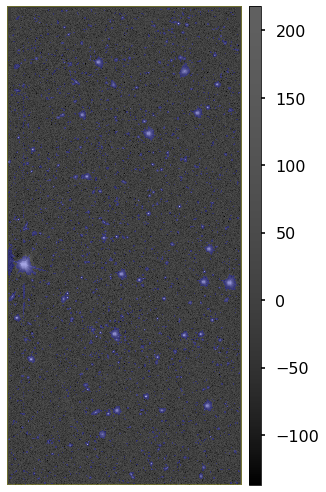

In [23]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage()[2000:2500,12000:12500])
plt.gca().axis('off')

## Forced Photometry: Combining Across Bands

Let's do one last example together, showing how you might exercise the forced photometry. As listed above in the steps that outline multi-band processing, the forced photometry catalogs unify objects across bands. To take advantage of this, we will make a color-color diagram. It's important to note that this would not be possible with the other detection products, as they have not had their peaks merged. Because Forced photometry happens after peaks have been merged, the jth row in the g band table is the same source as the jth row in the r band table, and so on. This is not the case in the other catalogs.

We need to first grab the forced photometry catalogs using the butler. Remember, these catalogs report instrumental fluxes, not magnitudes

In [ ]:
iSources = butler.get('deepCoadd_forced_src', dataId={'filter':'HSC-I', 'field':field, 'tract':15830, 'patch':'0,3'})
rSources = butler.get('deepCoadd_forced_src', dataId={'filter':'HSC-R', 'field':field, 'tract':15830, 'patch':'0,3'})
gSources = butler.get('deepCoadd_forced_src', dataId={'filter':'HSC-G', 'field':field, 'tract':15830, 'patch':'0,3'})
zSources = butler.get('deepCoadd_forced_src', dataId={'filter':'HSC-Z', 'field':field, 'tract':15830, 'patch':'0,3'})

To get magnitudes we will need photoCalibs from each filter. Fetch those with the butler too

In [ ]:
iCalib = butler.get('deepCoadd_calexp_photoCalib', dataId={'filter':'HSC-I', 'field':field, 'tract':15830, 'patch':'0,3'})
rCalib = butler.get('deepCoadd_calexp_photoCalib', dataId={'filter':'HSC-R', 'field':field, 'tract':15830, 'patch':'0,3'})
gCalib = butler.get('deepCoadd_calexp_photoCalib', dataId={'filter':'HSC-G', 'field':field, 'tract':15830, 'patch':'0,3'})
zCalib = butler.get('deepCoadd_calexp_photoCalib', dataId={'filter':'HSC-Z', 'field':field, 'tract':15830, 'patch':'0,3'})

Set up some quality control flags so we wont be dealing with too many junky sources. Partition the stars and galaxies into different samples

In [ ]:
noChildren = iSources['deblend_nChild'] == 0
isGoodFlux = ~iSources['modelfit_CModel_flag']
isStellar = iSources['base_ClassificationExtendedness_value'] < 1.
snr = iSources['modelfit_CModel_instFlux']/iSources['modelfit_CModel_instFluxErr'] > 10

gal_flag = noChildren & isGoodFlux & ~isStellar & snr
star_flag = noChildren & isGoodFlux & isStellar & snr

Calculate magnitudes and magnitude errors

In [ ]:
iMags = iCalib.instFluxToMagnitude(iSources, 'modelfit_CModel')
rMags = rCalib.instFluxToMagnitude(rSources, 'modelfit_CModel')
gMags = gCalib.instFluxToMagnitude(gSources, 'modelfit_CModel')
zMags = zCalib.instFluxToMagnitude(zSources, 'modelfit_CModel')

Make a color-color diagram. The stellar locus in this diagram will appear as red points. These are mostly Milky Way zero age main sequence stars, which overlap with galaxies that have simmilar stellar populations

In [ ]:
# plot r-i vs g-r for galaxies
plt.scatter(rMags[:,0][gal_flag] - iMags[:,0][gal_flag],
            gMags[:,0][gal_flag] - rMags[:,0][gal_flag],
           s=10, color='k', label='galaxies')
# plot r-i vs g-r fo stars on the same axis
plt.scatter(rMags[star_flag]-iMags[star_flag], gMags[star_flag]-rMags[star_flag],
            s=10, color='red', label='stars')
# zoom in on the interesting features
plt.xlim([-.5,2])
plt.ylim([-.5,2])
plt.xlabel('r - i')
plt.ylabel('g - r')
plt.legend()

### Exercise
Make a color *magnitude* diagram of stars only, and use psf fluxes to calculate magnitudes instead of CModel. This is borrowed from the [lsst science pipelines demo](https://pipelines.lsst.io/getting-started/multiband-analysis.html)

## Summary

Now you know how to detect, measure, and deblend images. You also know how to play around with detection configurations and measurement configurations to suit specific needs you may have if you are doing your own re-analysis. You should also be familiar with footprints, and their interplay between detection, deblending, and measurement. Finally, you learned how to navigate schemas and make plots using catalogs produced my the Science Pipelines.